# Using Supercheq with Cirq Superstaq

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Infleqtion/client-superstaq/blob/main/docs/source/apps/supercheq/Supercheq_css.ipynb) [![Launch Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/Infleqtion/client-superstaq/HEAD?labpath=docs/source/apps/supercheq/Supercheq_css.ipynb)

This notebook demonstrates how to use Supercheq, a novel quantum fingerprinting protocol developed by Infleqtion. Supercheq is built into the Superstaq server, and can be accessed using `cirq-superstaq`.

## Imports and API Token

This example tutorial notebook uses `cirq-superstaq`, our Superstaq client for Cirq; you can try it out by running `pip install cirq-superstaq`:

In [1]:
try:
    import cirq
    import cirq_superstaq as css
except ImportError:
    print("Installing cirq-superstaq...")
    %pip install --quiet 'cirq-superstaq[examples]'
    print("Installed cirq-superstaq.")
    print("You may need to restart the kernel to import newly installed packages.")
    import cirq
    import cirq_superstaq as css

In [2]:
# Required imports
import matplotlib.pyplot as plt
import numpy as np

# Optional imports
import os  # Used if setting a token as an environment variable

To interface Superstaq via Cirq, we must first instantiate a service provider in `cirq-superstaq` with `Service()`. We then supply a Superstaq API token (or key) by either providing the API token as an argument of `css.Service()` or by setting it as an environment variable (see more details [here](https://superstaq.readthedocs.io/en/latest/get_started/basics/basics_css.html#Set-up-access-to-Superstaq%E2%80%99s-API)).

In [3]:
# Get cirq superstaq service for Superstaq backend
service = css.Service()

## File Construction

To demonstrate Supercheq, we construct 32 files (for the sake of simplicitly, we just use lists in this notebook), each of length 5-bits. The lists represent the 32 different possible 5 bit values, so in theory these should all have distinguishable fingerprints.

In [4]:
# Demonstrate fingerprinting on all 32 5-bit bitstrings. We'll encode into just 3 qubits.
# fmt: off
files = [
    [0, 0, 0, 0, 0], [0, 0, 0, 0, 1], [0, 0, 0, 1, 0], [0, 0, 0, 1, 1],
    [0, 0, 1, 0, 0], [0, 0, 1, 0, 1], [0, 0, 1, 1, 0], [0, 0, 1, 1, 1],
    [0, 1, 0, 0, 0], [0, 1, 0, 0, 1], [0, 1, 0, 1, 0], [0, 1, 0, 1, 1],
    [0, 1, 1, 0, 0], [0, 1, 1, 0, 1], [0, 1, 1, 1, 0], [0, 1, 1, 1, 1],
    [1, 0, 0, 0, 0], [1, 0, 0, 0, 1], [1, 0, 0, 1, 0], [1, 0, 0, 1, 1],
    [1, 0, 1, 0, 0], [1, 0, 1, 0, 1], [1, 0, 1, 1, 0], [1, 0, 1, 1, 1],
    [1, 1, 0, 0, 0], [1, 1, 0, 0, 1], [1, 1, 0, 1, 0], [1, 1, 0, 1, 1],
    [1, 1, 1, 0, 0], [1, 1, 1, 0, 1], [1, 1, 1, 1, 0], [1, 1, 1, 1, 1],
]
# fmt: on

Supercheq uses quantum volume models to generate random circuits, using the file information as a seed. Hence, the final state vectors of the circuit act as a fingerprint for the file. Supercheq allows you to choose the number of qubits as well as circuit depth. To start with, we will use 3 qubits with a depth of 1.

In [5]:
num_qubits = 3
depth = 1
circuits, fidelities = service.supercheq(files, num_qubits, depth)

In [6]:
print(len(circuits))
print(fidelities.shape)

32
(32, 32)


Let's see what a couple of these circuits look like.

### Circuit for file [0, 0, 0, 0, 0]

In [7]:
circuits[0]

0: ───#2──────────────────────────────────────────────────────────I───
      │                                                           │
      ┌                                                       ┐   │
      │ 0.717+0.189j -0.376+0.25j   0.385-0.158j  0.19 -0.193j│   │
1: ───│ 0.082-0.441j  0.177-0.584j  0.461+0.263j  0.217-0.312j│───I───
      │ 0.052+0.048j  0.073-0.375j -0.281-0.634j  0.588+0.147j│   │
      │ 0.396+0.294j  0.252-0.462j -0.176-0.18j  -0.627-0.15j │   │
      └                                                       ┘   │
                                                                  │
2: ───────────────────────────────────────────────────────────────I───

### Circuit for file [0, 0, 0, 0, 1]

In [8]:
circuits[1]

0: ───#2──────────────────────────────────────────────────────────I───
      │                                                           │
1: ───┼───────────────────────────────────────────────────────────I───
      │                                                           │
      ┌                                                       ┐   │
      │ 0.497+0.534j -0.181+0.519j  0.244-0.276j -0.027+0.173j│   │
2: ───│ 0.354-0.223j -0.277-0.424j  0.193-0.341j -0.592-0.255j│───I───
      │-0.199+0.j     0.588+0.006j  0.482+0.011j -0.436+0.437j│
      │ 0.462+0.2j   -0.01 -0.309j -0.314+0.616j -0.19 +0.37j │
      └                                                       ┘

On first glance, these circuits look distinct (which is what we expect). However, we can't know for sure until we study the fidelities. The fidelity is calculated as the inner product of the final state vector pairs. For a good fingerprinting protocol, we would want all identical files to have a fidelity of 1, and distinct pairs to have a fidelity as close to 0 as possible.

The code blocks below allow you to visualize all of the fidelities simultaneously.

In [9]:
def plot_heatmap(fidelities):
    plt.figure(dpi=150)
    plt.imshow(fidelities)
    plt.colorbar()


def plot_histogram(fidelities):
    off_diag = np.tril(fidelities, -1)  # lower-right triangle of fidelities matrix
    on_diag = np.diag(fidelities)
    plt.figure(dpi=150)
    plt.hist([off_diag.flatten(), on_diag], label=["Off-Diagonal", "On-Diagonal"])
    plt.legend()

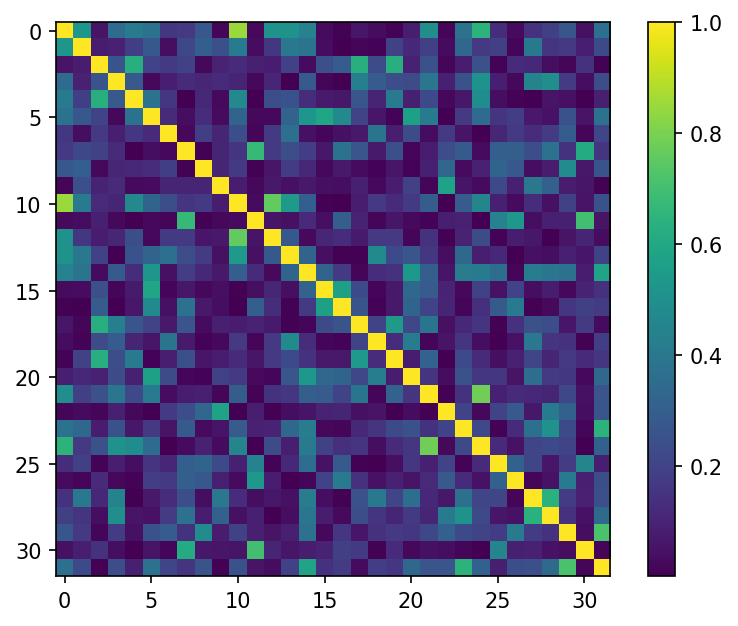

In [10]:
plot_heatmap(fidelities)

The above graph is a heatmap of the 32 different files and their fidelities with each other. It is essentially a visual representation of the fidelity matrix, with shades closer to yellow representing fidelity values close to one, and darker shades closer to blue/violet indication a fidelity close to 0. As expected, we have a yellow diagonal (1s), surrounded by much darker pixels (0s). 

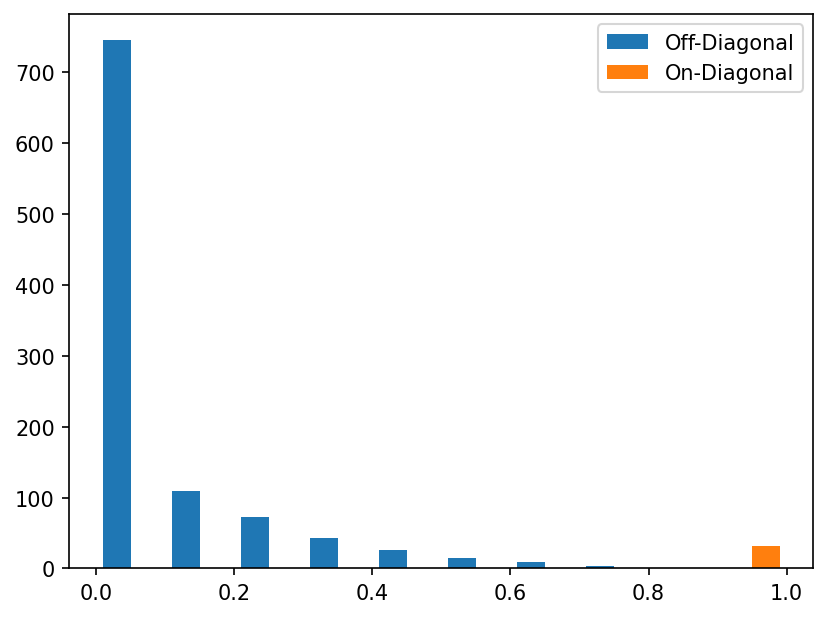

In [11]:
plot_histogram(fidelities)

In [12]:
np.sum(np.isclose(fidelities, 1))

32

We can look at the breakdown of fidelities using a histogram. As expected, there are 32 fidelities close to 1. 75% of the histogram entries are in the 0.0 bar, and the rest are distributed over the 0.1-0.6 range. This is a successful fingerprinting in that it pretty clearly distinguised identical pairs from separate ones, but we can do better and push the non identical fidelities closer to 0. We can achieve this by increasing the depth of the circuit or using more qubits.

---
### Scaling Depth

Instead of a circuit depth of 1, let's use 3.

In [13]:
num_qubits, depth = (3, 3)
circuits, fidelities = service.supercheq(files, num_qubits, depth)

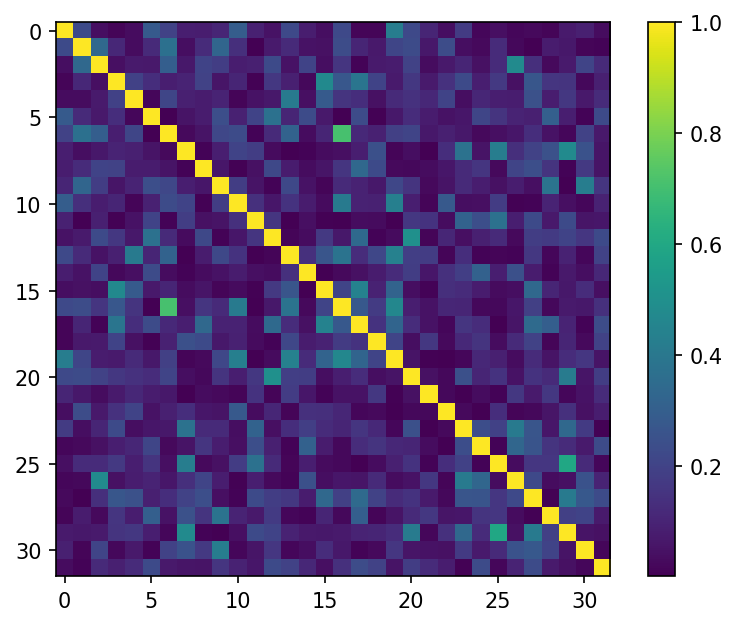

In [14]:
plot_heatmap(fidelities)

We see a visible improvement in results with a circuit depth of 6. There are fewer bright pixels around the diagonal, and the diagonal line is much clearer.

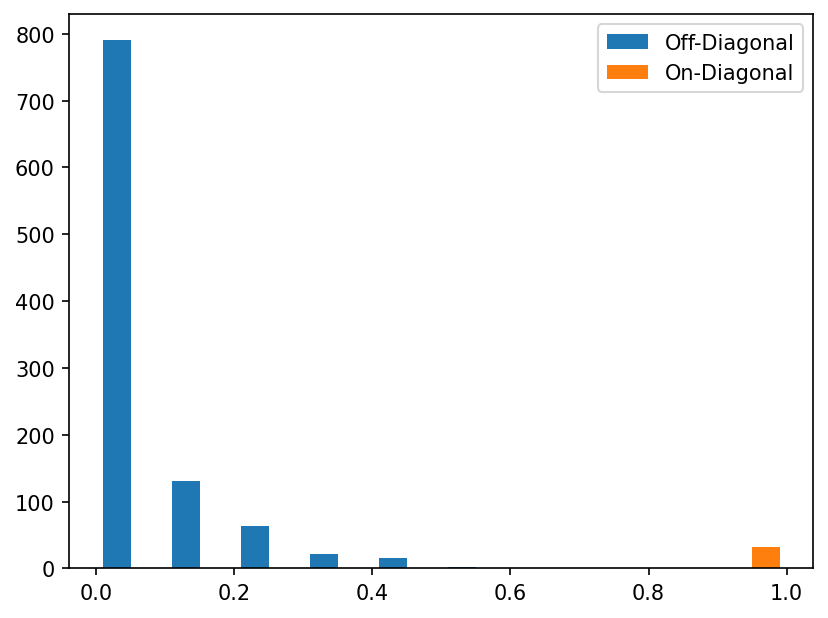

In [15]:
plot_histogram(fidelities)

Notice that the off-diagonals have moved slightly to the left in the histogram. Almost 80% of the pairs are in the 0 bar.

Let's try out a few more depths to see if we can get any more gains. The below code block calculates the average value of off diagonal elements for circuit dephts from 1 - 15. Better performance would entail an average off diagonal value closer to 0.

In [16]:
# This cell takes a couple of minutes to run.
mean_off_diags = []
for depth in range(1, 16):
    circuits, fidelities = service.supercheq(files, num_qubits, depth)
    off_diag = np.tril(fidelities, -1)
    mean_off_diags.append(np.mean(off_diag))

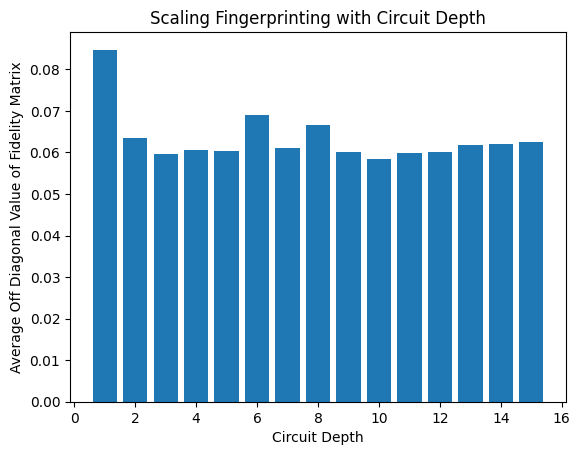

In [17]:
plt.bar(range(1, 16), mean_off_diags)
plt.xlabel("Circuit Depth")
plt.ylabel("Average Off Diagonal Value of Fidelity Matrix")
plt.title("Scaling Fingerprinting with Circuit Depth");

It seems like for these files, a circuit depth of 2 is sufficient. Deeper circuits don't seem to have significant gains. The average off diagonal fidelity seems to plateau around 0.06.

----
## Scaling number of qubits

We can similarly increase the number of qubits used. Here we use 4 instead of 3.

In [18]:
num_qubits, depth = (4, 1)
circuits, fidelities = service.supercheq(files, num_qubits, depth)

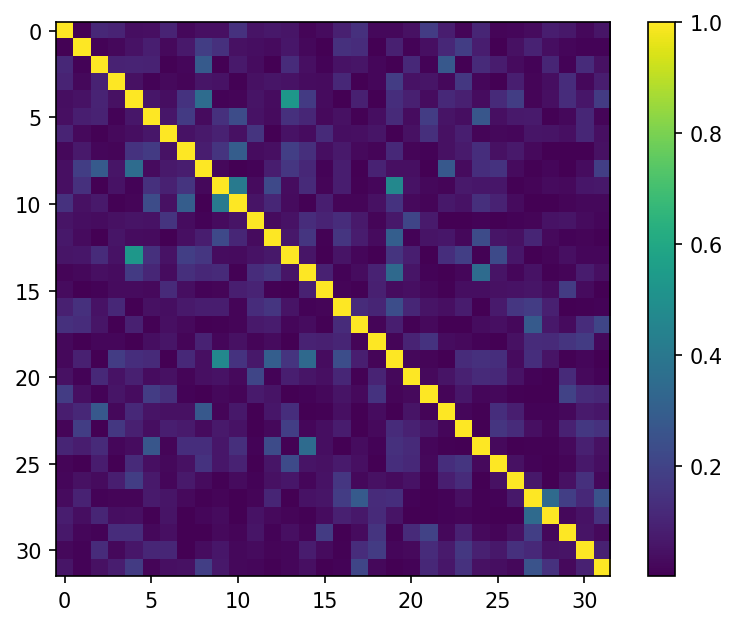

In [19]:
plot_heatmap(fidelities)

Again, we see a performance improvement. The off diagonal elements are all very dark. This is reflected in the histogram below, where about 90% of the off diagonal elements are in the 0.0 bar.

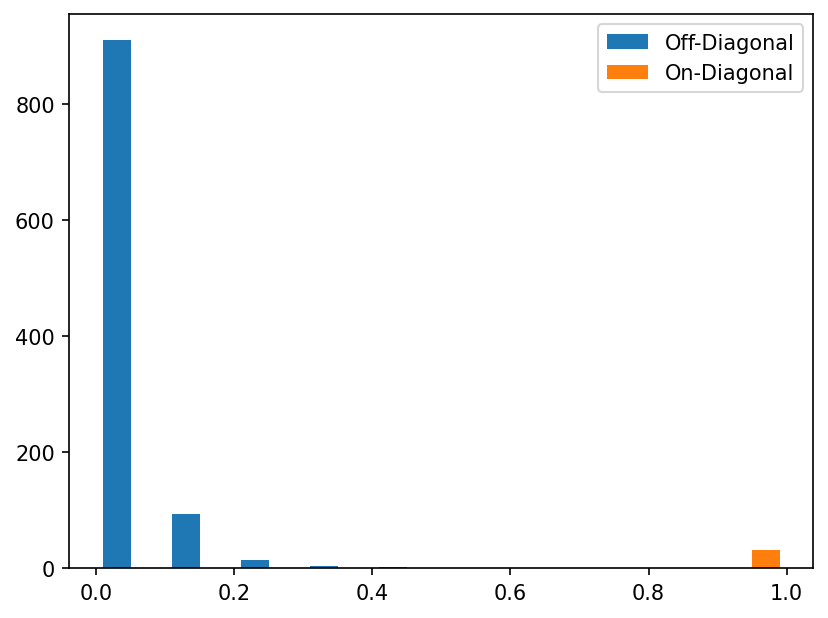

In [20]:
plot_histogram(fidelities)

Let's try out a few more qubit counts to see if we can get any more gains. The below code block calculates the average value of off diagonal elements for circuit dephts from 1 - 8. Better performance would entail an average off diagonal value closer to 0.

In [21]:
mean_off_diags = []
depth = 1
for num_qubits in range(1, 9):
    circuits, fidelities = service.supercheq(files, num_qubits, depth)
    off_diag = np.tril(fidelities, -1)
    mean_off_diags.append(np.mean(off_diag))

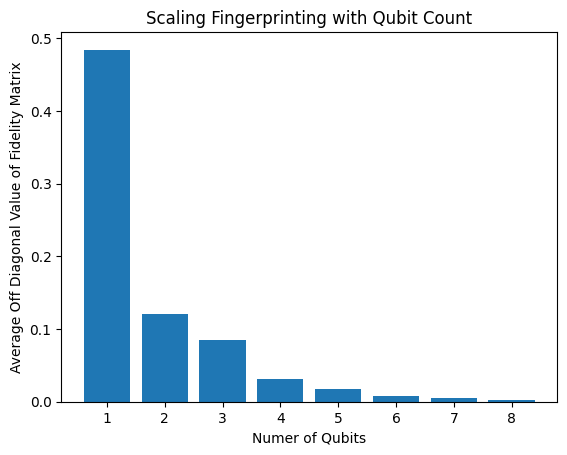

In [22]:
plt.bar(range(1, 9), mean_off_diags)
plt.xlabel("Numer of Qubits")
plt.ylabel("Average Off Diagonal Value of Fidelity Matrix")
plt.title("Scaling Fingerprinting with Qubit Count");

It seems like increasing the number of qubits is more powerful than increasing circuit depth for these circuits. The average value of off diagonal terms consistently decrease and tends towards 0. Below is the fidelity heatmap for 8 qubits. All the off diagonal elements are very close to 0 and virtually indististinguishable.

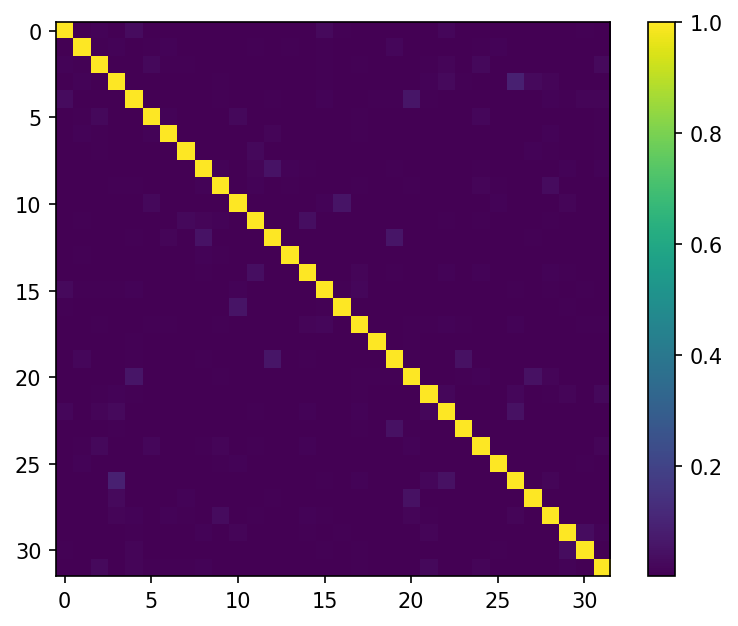

In [23]:
plot_heatmap(fidelities)

## Supercheq on files

Similar execution can be done with files instead of bitstrings

In [24]:
def encode_files(files):
    """Takes a list of files and encodes them as a list of lists of ones and zeroes"""
    encoded_files = []
    for i in files:
        f = open(i)
        lines = f.read()
        f.close()
        res = "".join(format(ord(j), "08b") for j in lines)
        encoded_file = []
        for k in res:
            encoded_file.append(int(k))
        encoded_files.append(encoded_file)
    return encoded_files

In [25]:
files = [
    "static/file.txt",
    "static/file1.txt",
    "static/file2.txt",
    "static/file3.txt",
    "static/file4.txt",
    "static/file5.txt",
    "static/file6.txt",
    "static/file7.txt",
    "static/file8.txt",
    "static/file9.txt",
    "static/file10.txt",
    "static/file11.txt",
    "static/file12.txt",
    "static/file13.txt",
    "static/file14.txt",
    "static/file15.txt",
    "static/file15.txt",
    "static/file16.txt",
    "static/file17.txt",
    "static/file18.txt",
    "static/file19.txt",
    "static/file20.txt",
]

In [26]:
encoded_files = encode_files(files)

In [27]:
num_qubits = 3
depth = 1
circuits, fidelities = service.supercheq(encoded_files, num_qubits, depth)

In [28]:
print(len(circuits))
print(fidelities.shape)

22
(22, 22)


In [29]:
circuits[0]

0: ───────────────────────────────────────────────────────────────I───
                                                                  │
1: ───#2──────────────────────────────────────────────────────────I───
      │                                                           │
      ┌                                                       ┐   │
      │ 0.339-0.033j  0.499-0.421j  0.222+0.333j -0.544-0.044j│   │
2: ───│ 0.452+0.28j  -0.484+0.272j -0.259+0.349j -0.31 +0.352j│───I───
      │ 0.469+0.309j -0.158-0.395j  0.168+0.162j  0.623-0.249j│
      │-0.462+0.269j -0.256+0.14j   0.634+0.442j -0.106-0.146j│
      └                                                       ┘

In [30]:
circuits[1]

┌                                                       ┐
      │ 0.127-0.737j -0.356-0.165j -0.015+0.362j  0.366+0.145j│
0: ───│-0.4  +0.008j  0.121-0.291j -0.799+0.112j  0.107-0.279j│───I───
      │ 0.376+0.328j -0.444+0.029j -0.049-0.207j  0.511-0.498j│   │
      │ 0.105-0.144j  0.486-0.559j  0.411+0.057j  0.05 -0.495j│   │
      └                                                       ┘   │
      │                                                           │
1: ───#2──────────────────────────────────────────────────────────I───
                                                                  │
2: ───────────────────────────────────────────────────────────────I───

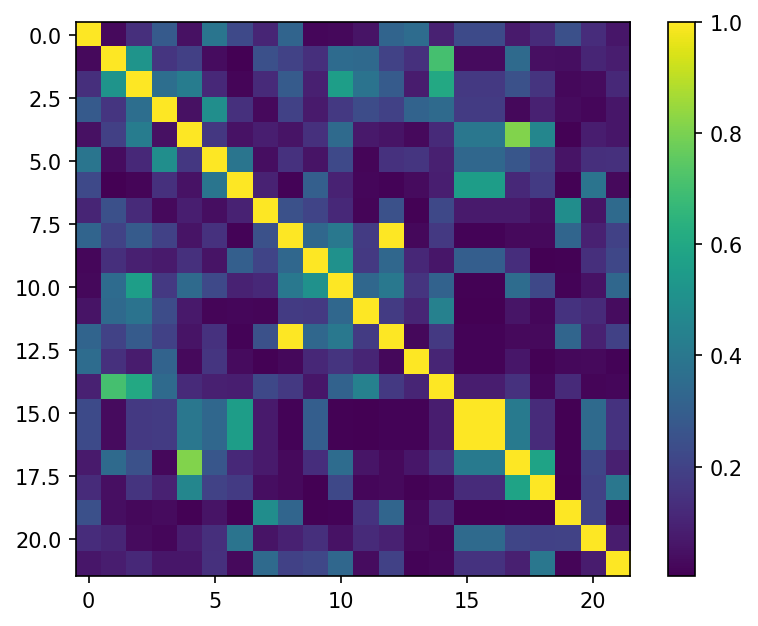

In [31]:
plot_heatmap(fidelities)

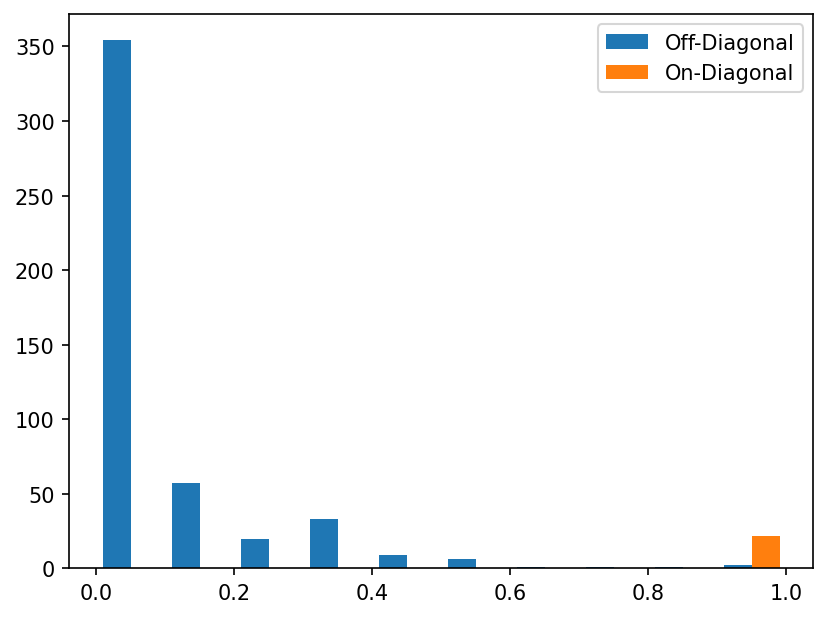

In [32]:
plot_histogram(fidelities)